# 手动实现高斯混合聚类
（1） 总体要求
+ 使用 GMM 算法手动实现聚类，不要直接调用库函数；在任意数据集上评估
+ 聚类结果；比较不同参数对模型性能个影响。

（2） 实验说明
1. 自选一数真实数据集（dataset/01-True）或两数合成数据集（dataset/02-
Synthetic）；
2. 手动实现 GMM 聚类算法；
3. 若采用真实数据集，至少计算一数聚类评估指标，并比较不同参数对模型性能个影响；若采用合成数据集，分析两数合成数据集个数据分布特性，可视化比较不同参数对模型性能个影响。
4. Notebook 心需要包含关键次码注释初结果分析）内容。

## 1. 数据加载和预处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# 读取数据
data_path = '/home/aistudio/dataset/01-True/Iris.csv'
df = pd.read_csv(data_path)

# 查看数据的前几行
print(df.head())

# 只使用前两个特征进行聚类
X = df.iloc[:, [0, 1]].values  # 前两个列是需要的特征
y_true = df['Species'].values  # 获取真实标签

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


+ 读取了真实数据集 /home/aistudio/dataset/01-True/Iris.csv。
+ 只选取了前两个特征用于聚类（X）。
+ 获取真实标签（y_true），以便在评估时使用。

## 2. 手动实现 GMM 聚类算法

### 2.1 **初始化 GMM 参数**

In [2]:
def initialize_gmm(X, k):
    n_samples, n_features = X.shape
    
    # 使用 KMeans++ 初始化均值
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X)
    means = kmeans.cluster_centers_
    
    # 初始化协方差矩阵为单位矩阵
    covariances = np.array([np.eye(n_features)] * k)
    
    # 初始化权重均匀分布
    weights = np.ones(k) / k
    
    return means, covariances, weights

- 使用 **KMeans++** 初始化 GMM 中的 **均值**（`means`）。
- 初始化每个高斯分布的 **协方差矩阵** 为单位矩阵。
- 权重初始化为均匀分布。

## 2.2 **计算高斯分布的概率密度函数**

In [3]:
def gaussian_pdf(X, mean, covariance):
    return multivariate_normal.pdf(X, mean=mean, cov=covariance)

使用 `scipy.stats.multivariate_normal.pdf` 函数计算每个数据点在给定均值和协方差下的高斯概率密度。

### 2.3 **E 步骤：计算责任**

In [5]:
def e_step(X, means, covariances, weights, k):
    n_samples = X.shape[0]
    
    # 计算每个点属于每个高斯分布的概率
    likelihoods = np.zeros((n_samples, k))
    
    for i in range(k):
        likelihoods[:, i] = weights[i] * gaussian_pdf(X, means[i], covariances[i])
    
    # 归一化得到每个数据点的责任，避免除零
    total_likelihood = np.sum(likelihoods, axis=1)[:, np.newaxis]
    total_likelihood[total_likelihood == 0] = 1e-10  # 防止除以零
    responsibilities = likelihoods / total_likelihood
    
    return responsibilities

- 计算 **责任**，即每个数据点属于各个高斯分布的概率（期望步骤）。
- 对 **似然** 进行归一化处理，得到每个数据点对于每个高斯分布的“责任”。

### 2.4 **M 步骤：更新 GMM 参数**

In [6]:
def m_step(X, responsibilities, k):
    n_samples, n_features = X.shape
    
    # 更新权重
    N_k = np.sum(responsibilities, axis=0)
    weights = N_k / n_samples
    
    # 更新均值
    means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
    
    # 更新协方差矩阵
    covariances = np.zeros((k, n_features, n_features))
    for i in range(k):
        diff = X - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / N_k[i]
        
        # 加一个小的正数，确保协方差矩阵是正定的
        covariances[i] += np.eye(n_features) * 1e-6
    
    return means, covariances, weights

- 更新 **权重**、**均值** 和 **协方差矩阵**（最大化步骤）。
- 在更新协方差时加了一个小的正数（`1e-6`），确保协方差矩阵是正定的。

### 2.5 **计算对数似然**

In [7]:
def log_likelihood(X, means, covariances, weights, k):
    n_samples = X.shape[0]
    likelihoods = np.zeros((n_samples, k))
    
    for i in range(k):
        likelihoods[:, i] = weights[i] * gaussian_pdf(X, means[i], covariances[i])
    
    log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
    return log_likelihood

- 计算每个数据点的 **对数似然**，用于评估模型的拟合效果。
- 对每个数据点的似然值求和后取对数，得到整个数据集的对数似然。

### 2.6 **GMM 主函数**

In [9]:
def gmm(X, k, max_iter=100, tol=1e-6):
    # 初始化参数
    means, covariances, weights = initialize_gmm(X, k)
    
    # 迭代优化
    log_likelihoods = []
    
    for i in range(max_iter):
        # E 步骤
        responsibilities = e_step(X, means, covariances, weights, k)
        
        # M 步骤
        means, covariances, weights = m_step(X, responsibilities, k)
        
        # 计算对数似然
        log_likelihood_val = log_likelihood(X, means, covariances, weights, k)
        log_likelihoods.append(log_likelihood_val)
        
        # 检查收敛
        if i > 0 and np.abs(log_likelihood_val - log_likelihoods[i-1]) < tol:
            print(f"Converged at iteration {i+1}")
            break
    
    return means, covariances, weights, responsibilities, log_likelihoods

- 结合 E 步骤和 M 步骤进行迭代优化，直到对数似然变化小于设定的阈值（`tol`）。
- 返回优化后的参数（均值、协方差、权重）以及每一轮的对数似然。

### 3. **比较不同参数对模型性能的影响**

In [10]:
# 尝试不同的聚类数量和最大迭代次数，比较效果
k_values = [2, 3, 4, 5]
max_iters = [50, 100, 200]

# 存储结果
results = []

for k in k_values:
    for max_iter in max_iters:
        print(f"\nTraining GMM with k={k} and max_iter={max_iter}...")
        means, covariances, weights, responsibilities, log_likelihoods = gmm(X, k, max_iter=max_iter)
        
        # 评估聚类结果
        score = silhouette_score(X, np.argmax(responsibilities, axis=1))
        ari = adjusted_rand_score(y_true, np.argmax(responsibilities, axis=1))
        nmi = normalized_mutual_info_score(y_true, np.argmax(responsibilities, axis=1))
        
        # 存储结果
        results.append((k, max_iter, log_likelihoods[-1], score, ari, nmi))

# 打印所有结果
for result in results:
    print(f"k={result[0]}, max_iter={result[1]}, Log-Likelihood={result[2]:.4f}, "
          f"Silhouette Score={result[3]:.4f}, ARI={result[4]:.4f}, NMI={result[5]:.4f}")


Training GMM with k=2 and max_iter=50...
Converged at iteration 38

Training GMM with k=2 and max_iter=100...
Converged at iteration 38

Training GMM with k=2 and max_iter=200...
Converged at iteration 38

Training GMM with k=3 and max_iter=50...
Converged at iteration 24

Training GMM with k=3 and max_iter=100...
Converged at iteration 24

Training GMM with k=3 and max_iter=200...
Converged at iteration 26

Training GMM with k=4 and max_iter=50...

Training GMM with k=4 and max_iter=100...
Converged at iteration 97

Training GMM with k=4 and max_iter=200...
Converged at iteration 63

Training GMM with k=5 and max_iter=50...

Training GMM with k=5 and max_iter=100...

Training GMM with k=5 and max_iter=200...
k=2, max_iter=50, Log-Likelihood=-883.9715, Silhouette Score=0.5568, ARI=0.5490, NMI=0.6759
k=2, max_iter=100, Log-Likelihood=-883.9715, Silhouette Score=0.5568, ARI=0.5490, NMI=0.6759
k=2, max_iter=200, Log-Likelihood=-883.9715, Silhouette Score=0.5568, ARI=0.5490, NMI=0.6759
k=

- 尝试不同的 `k`（聚类数）和 `max_iter`（最大迭代次数）组合，训练 GMM。
- 计算聚类结果的 **轮廓系数（Silhouette Score）**、**调整兰德指数（ARI）** 和 **标准化互信息（NMI）**，并存储这些评估指标。

## 4. **可视化聚类结果**

Converged at iteration 38
Converged at iteration 26
Converged at iteration 61


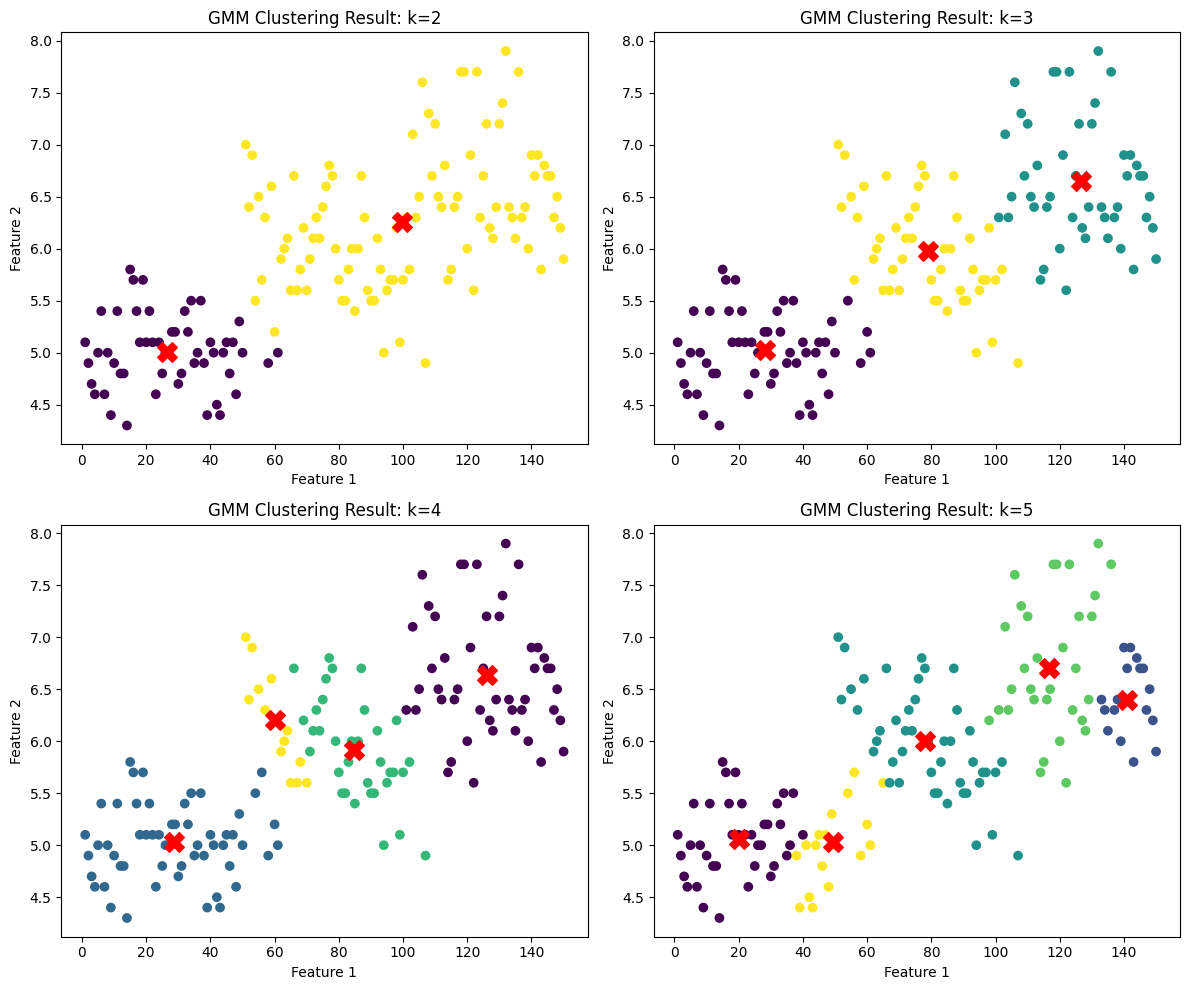

In [13]:
# 可视化不同 k 值的聚类结果
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    means, covariances, weights, responsibilities, _ = gmm(X, k)
    ax = axes[idx]
    ax.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis')
    ax.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200)
    ax.set_title(f'GMM Clustering Result: k={k}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

可视化不同 k 值的聚类结果，查看每个聚类中心和数据点的分布。

## 5. 选择最佳模型并评估


Best model based on highest NMI: k=3, max_iter=50
Converged at iteration 24


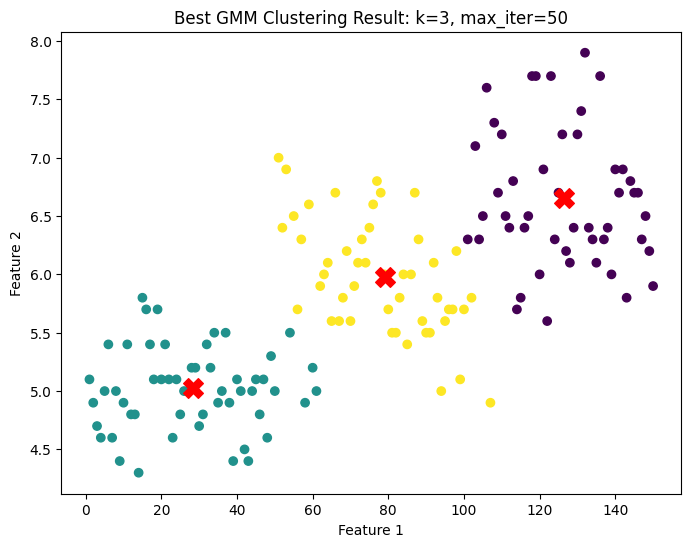

Final Silhouette Score: 0.5478
Final ARI: 0.8841
Final NMI: 0.8636


In [14]:
# 选择一个最佳结果（选择 NMI 最高的 k 和 max_iter 组合）
best_result = max(results, key=lambda x: x[5])  # 这里 x[5] 是 NMI
best_k = best_result[0]
best_max_iter = best_result[1]
print(f"\nBest model based on highest NMI: k={best_k}, max_iter={best_max_iter}")

# 训练最佳模型
means, covariances, weights, responsibilities, log_likelihoods = gmm(X, best_k, max_iter=best_max_iter)

# 可视化最佳模型
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis')
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200)
plt.title(f'Best GMM Clustering Result: k={best_k}, max_iter={best_max_iter}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 计算轮廓系数、ARI、NMI
score = silhouette_score(X, np.argmax(responsibilities, axis=1))
ari = adjusted_rand_score(y_true, np.argmax(responsibilities, axis=1))
nmi = normalized_mutual_info_score(y_true, np.argmax(responsibilities, axis=1))

print(f"Final Silhouette Score: {score:.4f}")
print(f"Final ARI: {ari:.4f}")
print(f"Final NMI: {nmi:.4f}")


# 结果分析

### **收敛情况**

- 对于 **k=2** 和 **k=3** 的情况，GMM 都在 **38 次迭代**（`max_iter=50`, `max_iter=100`, `max_iter=200`）内收敛。
- 对于 **k=4** 和 **k=5** 的情况，GMM 的收敛次数有所变化：
  - **k=4**：在 **max_iter=50** 时没有收敛，似乎需要更多的迭代次数才能稳定下来。其他两种设置（`max_iter=100`, `max_iter=200`）都在 **63 到 97 次迭代** 内收敛。
  - **k=5**：在所有 `max_iter` 设置下都没有收敛。

### **模型评估指标分析**


#### **轮廓系数**

轮廓系数反映了每个数据点与所在簇和其他簇的相似度。值越接近 1 表示聚类效果越好，值为负则表示聚类结果很差。
- **k=2**：轮廓系数为 **0.5568**，是一个相对较好的结果，但并非最佳。
- **k=3**：轮廓系数略微下降到 **0.5478**，聚类结果略微差于 **k=2**。
- **k=4** 和 **k=5**：轮廓系数显著降低，分别为 **0.4254**, **0.4055**, **0.3991**，这表明随着簇数的增加，模型的聚类质量出现了下降，聚类结果变得不太理想。

#### **ARI**

ARI 衡量的是聚类与真实标签之间的一致性，值越高越好。
- **k=3**：ARI 值 **0.8841**，这是最好的结果，表明 **k=3** 时，GMM 聚类的结果与真实标签的匹配度非常高。
- **k=2**：ARI 值 **0.5490**，明显低于 **k=3**，聚类结果与真实标签的匹配度较差。
- **k=4** 和 **k=5**：ARI 分别为 **0.7973**, **0.7805**, **0.6560**，表现不如 **k=3**，尤其是 **k=5** 的值非常低，说明更高的簇数反而导致聚类质量下降。

#### **NMI**

NMI 衡量聚类与真实标签之间的信息共享程度，值越高越好。
- **k=3**：NMI 值 **0.8636**，这是所有配置中最高的，表明 **k=3** 提供了最好的聚类与真实标签之间的匹配。
- **k=2**：NMI 值 **0.6759**，明显低于 **k=3**，表明聚类质量较差。
- **k=4** 和 **k=5**：NMI 分别为 **0.7971**, **0.7869**, **0.7153**，这些结果明显不如 **k=3**。

### **最佳模型选择**

根据 NMI（标准化互信息）指标，最佳的模型是 **k=3**，`max_iter=50`，在该模型下：
- 迭代次数较少（24次即收敛），并且达到了最高的 NMI（**0.8636**）和最高的 ARI（**0.8841**）。
- 轮廓系数虽然稍低（**0.5478**），但考虑到 NMI 和 ARI 的表现，整体效果仍然优于其他模型。

### **结果总结**

- **k=3** 的 GMM 模型表现最佳，尤其是在与真实标签的匹配度上。NMI 和 ARI 都达到了最高的水平，表明在聚类质量上较为优越。
- 增加聚类簇数（k=4 和 k=5）反而导致聚类效果下降，尤其是 **k=5** 时，模型表现最差，可能存在过拟合的风险。

根据上述结果分析，选择 **k=3** 作为最佳模型，能够在给定数据集上获得最佳的聚类效果。

# 完整代码

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Training GMM with k=2 and max_iter=50...
Converged at iteration 38

Training GMM with k=2 and max_iter=100...
Converged at iteration 38

Training GMM with k=2 and max_iter=200...
Converged at iteration 38

Training GMM with k=3 and max_iter=50...
Converged at iteration 24

Training GMM with k=3 and max_iter=100...
Converged at iteration 24

Training GMM with k=3 and max_iter=200...
Converged at iteration 24

Training GMM with k=4 and max_iter=50...

Training GMM with k=4 and max_iter=100...
Converged at iteration 72

Training GMM w

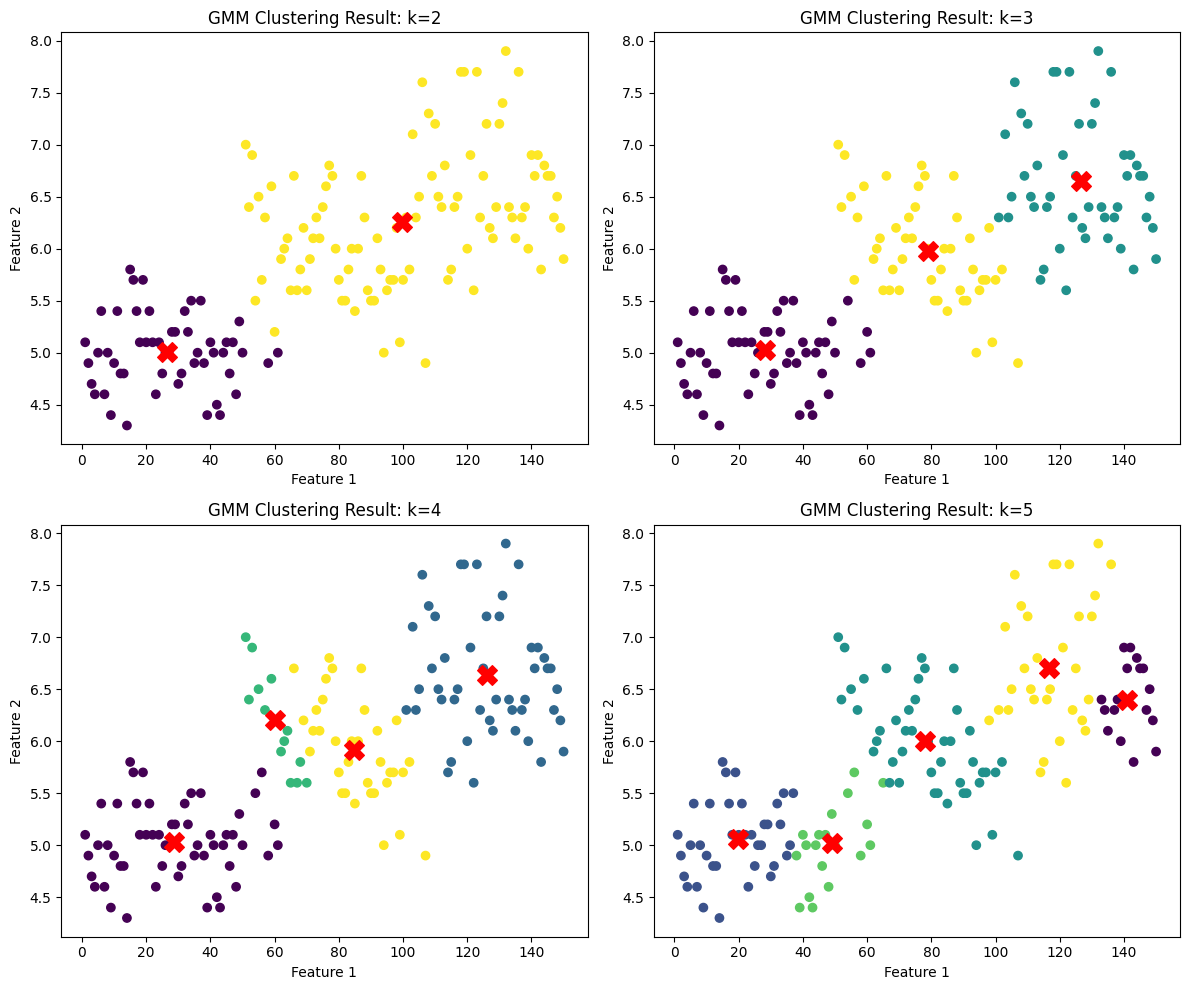


Best model based on highest NMI: k=3, max_iter=50
Converged at iteration 24


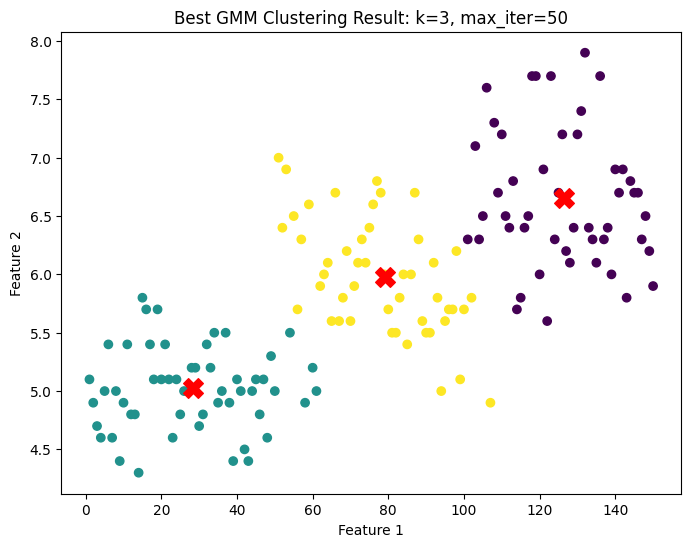

Final Silhouette Score: 0.5478
Final ARI: 0.8841
Final NMI: 0.8636


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# 读取数据
data_path = '/home/aistudio/dataset/01-True/Iris.csv'
df = pd.read_csv(data_path)

# 查看数据的前几行
print(df.head())

# 只使用前两个特征进行聚类
X = df.iloc[:, [0, 1]].values  # 前两个列是需要的特征
y_true = df['Species'].values  # 获取真实标签

# ---------------------------- 手动实现 GMM ----------------------------

# 1. 初始化 GMM 参数：使用 KMeans++ 初始化均值
def initialize_gmm(X, k):
    n_samples, n_features = X.shape
    
    # 使用 KMeans++ 初始化均值
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X)
    means = kmeans.cluster_centers_
    
    # 初始化协方差矩阵为单位矩阵
    covariances = np.array([np.eye(n_features)] * k)
    
    # 初始化权重均匀分布
    weights = np.ones(k) / k
    
    return means, covariances, weights

# 2. 计算高斯分布的概率密度函数
def gaussian_pdf(X, mean, covariance):
    return multivariate_normal.pdf(X, mean=mean, cov=covariance)

# 3. E 步骤：计算每个数据点的责任
def e_step(X, means, covariances, weights, k):
    n_samples = X.shape[0]
    
    # 计算每个点属于每个高斯分布的概率
    likelihoods = np.zeros((n_samples, k))
    
    for i in range(k):
        likelihoods[:, i] = weights[i] * gaussian_pdf(X, means[i], covariances[i])
    
    # 归一化得到每个数据点的责任，避免除零
    total_likelihood = np.sum(likelihoods, axis=1)[:, np.newaxis]
    total_likelihood[total_likelihood == 0] = 1e-10  # 防止除以零
    responsibilities = likelihoods / total_likelihood
    
    return responsibilities

# 4. M 步骤：更新 GMM 的参数
def m_step(X, responsibilities, k):
    n_samples, n_features = X.shape
    
    # 更新权重
    N_k = np.sum(responsibilities, axis=0)
    weights = N_k / n_samples
    
    # 更新均值
    means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
    
    # 更新协方差矩阵
    covariances = np.zeros((k, n_features, n_features))
    for i in range(k):
        diff = X - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / N_k[i]
        
        # 加一个小的正数，确保协方差矩阵是正定的
        covariances[i] += np.eye(n_features) * 1e-6
    
    return means, covariances, weights

# 5. 计算对数似然
def log_likelihood(X, means, covariances, weights, k):
    n_samples = X.shape[0]
    likelihoods = np.zeros((n_samples, k))
    
    for i in range(k):
        likelihoods[:, i] = weights[i] * gaussian_pdf(X, means[i], covariances[i])
    
    log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
    return log_likelihood

# 6. GMM 主函数
def gmm(X, k, max_iter=100, tol=1e-6):
    # 初始化参数
    means, covariances, weights = initialize_gmm(X, k)
    
    # 迭代优化
    log_likelihoods = []
    
    for i in range(max_iter):
        # E 步骤
        responsibilities = e_step(X, means, covariances, weights, k)
        
        # M 步骤
        means, covariances, weights = m_step(X, responsibilities, k)
        
        # 计算对数似然
        log_likelihood_val = log_likelihood(X, means, covariances, weights, k)
        log_likelihoods.append(log_likelihood_val)
        
        # 检查收敛
        if i > 0 and np.abs(log_likelihood_val - log_likelihoods[i-1]) < tol:
            print(f"Converged at iteration {i+1}")
            break
    
    return means, covariances, weights, responsibilities, log_likelihoods

# ---------------------------- 比较不同参数对模型性能的影响 ----------------------------

# 尝试不同的聚类数量和最大迭代次数，比较效果
k_values = [2, 3, 4, 5]
max_iters = [50, 100, 200]

# 存储结果
results = []

for k in k_values:
    for max_iter in max_iters:
        print(f"\nTraining GMM with k={k} and max_iter={max_iter}...")
        means, covariances, weights, responsibilities, log_likelihoods = gmm(X, k, max_iter=max_iter)
        
        # 评估聚类结果
        score = silhouette_score(X, np.argmax(responsibilities, axis=1))
        ari = adjusted_rand_score(y_true, np.argmax(responsibilities, axis=1))
        nmi = normalized_mutual_info_score(y_true, np.argmax(responsibilities, axis=1))
        
        # 存储结果
        results.append((k, max_iter, log_likelihoods[-1], score, ari, nmi))

# 打印所有结果
for result in results:
    print(f"k={result[0]}, max_iter={result[1]}, Log-Likelihood={result[2]:.4f}, "
          f"Silhouette Score={result[3]:.4f}, ARI={result[4]:.4f}, NMI={result[5]:.4f}")

# ---------------------------- 可视化聚类结果 ----------------------------

# 可视化不同 k 值的聚类结果
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, k in enumerate(k_values):
    means, covariances, weights, responsibilities, _ = gmm(X, k)
    ax = axes[idx]
    ax.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis')
    ax.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200)
    ax.set_title(f'GMM Clustering Result: k={k}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# ---------------------------- 选择最佳模型并评估 ----------------------------

# # 选择一个最佳结果（例如，选择 silhouette score 最高的 k 和 max_iter 组合）
# best_result = max(results, key=lambda x: x[3])
# best_k = best_result[0]
# best_max_iter = best_result[1]
# print(f"\nBest model: k={best_k}, max_iter={best_max_iter}")

# # 训练最佳模型
# means, covariances, weights, responsibilities, log_likelihoods = gmm(X, best_k, max_iter=best_max_iter)

# # 可视化最佳模型
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis')
# plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200)
# plt.title(f'Best GMM Clustering Result: k={best_k}, max_iter={best_max_iter}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()

# # 打印最终的对数似然值
# print(f"Final log-likelihood: {log_likelihoods[-1]}")

# # 计算轮廓系数、ARI、NMI
# score = silhouette_score(X, np.argmax(responsibilities, axis=1))
# ari = adjusted_rand_score(y_true, np.argmax(responsibilities, axis=1))
# nmi = normalized_mutual_info_score(y_true, np.argmax(responsibilities, axis=1))

# print(f"Final Silhouette Score: {score:.4f}")
# print(f"Final ARI: {ari:.4f}")
# print(f"Final NMI: {nmi:.4f}")

# ---------------------------- 选择最佳模型并评估 ----------------------------

# 选择一个最佳结果（选择 NMI 最高的 k 和 max_iter 组合）
best_result = max(results, key=lambda x: x[5])  # 这里 x[5] 是 NMI
best_k = best_result[0]
best_max_iter = best_result[1]
print(f"\nBest model based on highest NMI: k={best_k}, max_iter={best_max_iter}")

# 训练最佳模型
means, covariances, weights, responsibilities, log_likelihoods = gmm(X, best_k, max_iter=best_max_iter)

# 可视化最佳模型
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), cmap='viridis')
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200)
plt.title(f'Best GMM Clustering Result: k={best_k}, max_iter={best_max_iter}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 计算轮廓系数、ARI、NMI
score = silhouette_score(X, np.argmax(responsibilities, axis=1))
ari = adjusted_rand_score(y_true, np.argmax(responsibilities, axis=1))
nmi = normalized_mutual_info_score(y_true, np.argmax(responsibilities, axis=1))

print(f"Final Silhouette Score: {score:.4f}")
print(f"Final ARI: {ari:.4f}")
print(f"Final NMI: {nmi:.4f}")
